<a name="polyp-segmentation:-image-preprocessing,-data-generator,-and-modeling"></a>
# Polyp Segmentation: Image Preprocessing, Data Generator, and Modeling

<a name="objectives"></a>
## Objective
In the previous notebook, we have explored the polyp images and masks, as well as split data into train, validation, and test set.

In this notebook, we wil take the data sets and generate batches of tensor image data with real-time data augmentation, then use them for training our segmentation model.

## Table of Contents
  * [Polyp Segmentation: Image Preprocessing, Data Generator, and Modeling](#polyp-segmentation:-image-preprocessing,-data-generator,-and-modeling)
    * [Objective](#objectives)
    * [Table of Contents](#table-of-contents)
    * [Import Modules](#import-moduless)
    * [Connect Google Drive](#connect-google-drive)
    * [Prepare Batches of Images with ImageDataGenerator](#prepare-batches-of-images-with-imagedatagenerator)
      * [Generate data batches](#generate-data-batches)
      * [Inspect Genereated Batches](#inspect-genereated-batches)
      * [Train batches](#train-batches)
      * [Validation batches](#validation-batches)
      * [Test batch](#test-batch)
    * [Build and Train Polyp Segmentation Model: U-Net](#build-and-train-polyp-segmentation-model:-u-net)
      * [What is U-Net?](#what-is-u-net?)
      * [Model architercture](#model-architercture)
      * [Model configuration](#model-configuration)
      * [Model training](#model-training)
    * [Evaluate Trained U-Net Model](#evaluate-trained-u-net-model)
      * [Confusion matrix](#confusion-matrix)
      * [Precision and Recall](#precision-and-recall)
      * [IoU and Dice coefficient (F1 score)](#iou-and-dice-coefficient-(f1-score))
      * [Mask prediction](#mask-prediction)
    * [Conclusion](#conclusion)
      * [Strengths](#strengths)
      * [Areas for Improvement](#areas-for-improvement)
      * [Recommendations](#recommendations)
    * [Limitations of U-Net Architecture](#limitations-of-u-net-architecture)
      * [Current state of art model: Meta-Polyp](#current-state-of-art-model:-meta-polyp)

<a name="import-moduless"></a>
## Import Modules

Let's first pull out the necessary modules for this notebook.

In [ ]:
# TensorFlow's Keras API for image data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Matplotlib and Seaborn for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NumPy for numerical operations
import numpy as np

# Random for generating random numbers
import random

# TensorFlow for machine learning operations
import tensorflow as tf

# Keras Model and layers for building the U-Net architecture
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate

# Regularizers and Optimizers for the model
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam

# Callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report

<a name="connect-google-drive"></a>
## Connect Google Drive

We will be training our model on Google Colab, therefore we will need to upload our image data to Google Drive and connect this notebook to the path where the images are stored.

In [ ]:
# Importing the necessary module from Google Colab
from google.colab import drive

# Mounting Google Drive to access files
drive.mount('/content/drive')

# Changing the current directory to the Polyp segmentation folder
%cd '/content/drive/MyDrive/Polyp segmentation'

Mounted at /content/drive
/content/drive/MyDrive/Polyp segmentation


<a name="prepare-batches-of-images-with-imagedatagenerator"></a>
## Prepare Batches of Images with ImageDataGenerator

During model training, it is common to train the model on a subset of the training data at a time, known as mini-batches. `ImageDataGenerator` can generate these mini-batches by randomly sampling and augmenting the images. It simplifies the process of preparing the data for training by automatically generating batches of augmented images.

In order to set up the generator properly, our image data is organized the same as the following structure. Note that it's important to make sure the images and masks within the set are stored in their respected subfolders with the same name. For example, both test images and test masks are stored in their respected subfolders with the same name "test".
```
new_data
├── test
│   ├── images
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   
├── train
│   ├── images
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   
├── valid
│   ├── images
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...


```

<a name="generate-data-batches"></a>
### Generate data batches

Before we generate te batches, we will rescale our image data to range of 0 to 1. We want to ensure that the data falls within a similar range and has a consistent scale, which can improve the performance and convergence of the model.

We also apply data augmentation technique to increase the diversity and variability of the training data by applying random transformations to the images. By applying random transformations such as  flipping, rotation, zooming, shearing, and random shifts, we can create variations of the original images. This helps in improving the generalization and robustness of the deep learning model by exposing it to a wider range of image variations.

In [ ]:
def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):
    """
    Generate data batches for image segmentation tasks.

    Args:
        data_dir (str): The directory containing the dataset with subdirectories for train, validation, and test sets.
        batch_size (int): The batch size to use for the data generators.
        target_size (tuple): The target size to resize the images and masks, specified as (height, width).
        seed (int or None, optional): Random seed for reproducibility. Defaults to None.
        train_augmentation (bool, optional): Flag to enable data augmentation for the training set. Defaults to False.

    Returns:
        tuple: A tuple containing the following data generators:
            - train_images_generator (DirectoryIterator): Data generator for training set images.
            - train_masks_generator (DirectoryIterator): Data generator for training set masks.
            - valid_images_generator (DirectoryIterator): Data generator for validation set images.
            - valid_masks_generator (DirectoryIterator): Data generator for validation set masks.
            - test_images_generator (DirectoryIterator): Data generator for test set images.
            - test_masks_generator (DirectoryIterator): Data generator for test set masks.
    """

    # Rescaling factor for all sets
    rescale_factor = 1.0 / 255.0

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Data augmentation for the training set
    if train_augmentation:
        train_data_generator = ImageDataGenerator(
            rescale=rescale_factor,
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.7, 1.3],
            fill_mode='reflect',
        )
    else:
        train_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Data generators for validation and test sets (without augmentation)
    valid_data_generator = ImageDataGenerator(rescale=rescale_factor)
    test_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Flow data from directories and apply augmentation where applicable
    train_images_generator = train_data_generator.flow_from_directory(
        data_dir + '/train/images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        #color_mode = 'grayscale',
        shuffle=True, #shuffle to introduce randomness for better better generalization
        seed=seed
    )

    train_masks_generator = train_data_generator.flow_from_directory(
        data_dir + '/train/masks',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=True, #shuffle to introduce randomness for better better generalization
        seed=seed
    )

    valid_images_generator = valid_data_generator.flow_from_directory(
        data_dir + '/valid/images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        #color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper evaluation of the model's performance
        seed=seed
    )

    valid_masks_generator = valid_data_generator.flow_from_directory(
        data_dir + '/valid/masks',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper evaluation of the model's performance
        seed=seed
    )

    test_images_generator = test_data_generator.flow_from_directory(
        data_dir + '/test/images',
        target_size=target_size,
        batch_size=100, # set test batch size = full test sample size
        class_mode=None,
        #color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper prediction of the model's performance
        seed=seed
    )

    test_masks_generator = test_data_generator.flow_from_directory(
        data_dir + '/test/masks',
        target_size=target_size,
        batch_size=100, # set test batch size = full test sample size
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper prediction of the model's performance
        seed=seed
    )

    return (
        train_images_generator, train_masks_generator,
        valid_images_generator, valid_masks_generator,
        test_images_generator, test_masks_generator
    )

In [ ]:
# Set parameters for `generate_data_batches` functon
data_dir = './new_data/'
batch_size = 16
seed = 123
target_size = (256, 256)

# Generate the data batches using the specified parameters
(train_images_gen, train_masks_gen,
 validation_images_gen, validation_masks_gen,
 test_images_gen, test_masks_gen) = generate_data_batches(
    data_dir,
    batch_size,
    target_size=target_size,
    seed=seed,
    train_augmentation=True
)

# Pack train generator as `(x, y)` and validation genereators as `(x_val, y_val)`
train_generator = zip(train_images_gen, train_masks_gen)
val_generator = zip(validation_images_gen, validation_masks_gen)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


<a name="inspect-genereated-batches"></a>
### Inspect Genereated Batches

Once we set up the data generators for the training, validation, and testing sets, we can have a look at the content of the data batches.

Let's start with train data batches.

<a name="train-batches"></a>
#### Train batches

If we divide the number of available samples by the specified batch size, we will get the steps which will be passed as argument when training our segmentation model.

In [ ]:
# Get the number of samples in the train images
train_samples = train_images_gen.samples

# Get the batch size
batch_size = train_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Images")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Images
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


In [ ]:
# Get the number of samples in the train masks
train_samples = train_masks_gen.samples

# Get the batch size
batch_size = train_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Masks")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Masks
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


Let's visualize some examples of our train batches. We will look at the first 5 images of our first 3 batches.

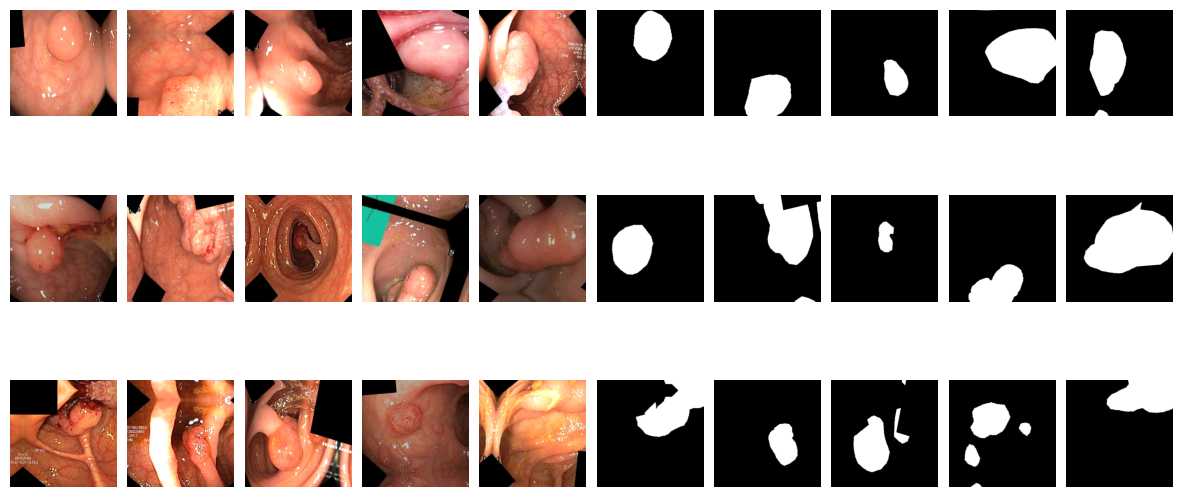

In [ ]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = train_images_gen.next()[:images_per_batch]
    batch_masks = train_masks_gen.next()[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
print("Minimum train image pixel value:", batch_images[0].min())
print("Maximum train image pixel value:", batch_images[0].max())
print("Minimum train mask pixel value:", batch_masks[0].min())
print("Maximum train mask pixel value:", batch_masks[0].max())

Minimum train image pixel value: 0.0
Maximum train image pixel value: 1.0
Minimum train mask pixel value: 0.0
Maximum train mask pixel value: 1.0


We can see that in the previous notebook, the minimum and maximum pixel value of our image is (0, 255). After rescaling, the the minimum and maximum pixel value of our image is between 0 and 1.


<a name="validation-batches"></a>
#### Validation batches

For validation batches, the number of steps is smaller as compared to train batches as we have lesser samples in the validation set than in the train set.

In [ ]:
# Get the number of samples in the validation images
validation_samples = validation_images_gen.samples

# Get the batch size
batch_size = validation_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Validation Images")
print("Number of samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of batches (validation steps):", round(validation_steps))

Validation Images
Number of samples: 100
Batch size: 16
Number of batches (validation steps): 6


In [ ]:
# Get the number of samples in the validation masks
validation_samples = validation_masks_gen.samples

# Get the batch size
batch_size = validation_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Validation Masks")
print("Number of validation samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of validation batches (validation steps):", round(validation_steps))

Validation Masks
Number of validation samples: 100
Batch size: 16
Number of validation batches (validation steps): 6


Let's visualize some examples of our validation batches. We will look at the first 5 images of our first 3 batches.

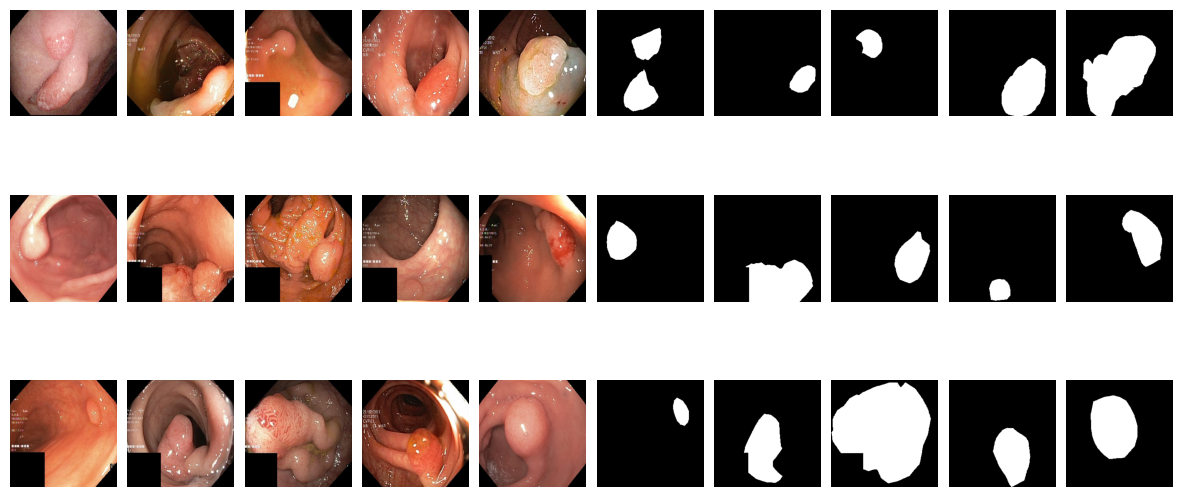

In [ ]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = validation_images_gen.next()[:images_per_batch]
    batch_masks = validation_masks_gen.next()[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
print("Minimum validation image pixel value:", batch_images[0].min())
print("Maximum validation image pixel value:", batch_images[0].max())
print("Minimum validation mask pixel value:", batch_masks[0].min())
print("Maximum validation mask pixel value:", batch_masks[0].max())

Minimum validation image pixel value: 0.0
Maximum validation image pixel value: 1.0
Minimum validation mask pixel value: 0.0
Maximum validation mask pixel value: 1.0


Same as the train batches, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="test-batch"></a>
#### Test batch

For test batch, we don't need to calculate the number of steps and pass it in as argument during model training as we only use the test batch for model evaluation.

We set the test batch size to full test sample size therefore there will be just one step. We can verify the test batch size.

In [ ]:
test_images_gen.batch_size

100

Let's visualize first 15 images of our test batch.

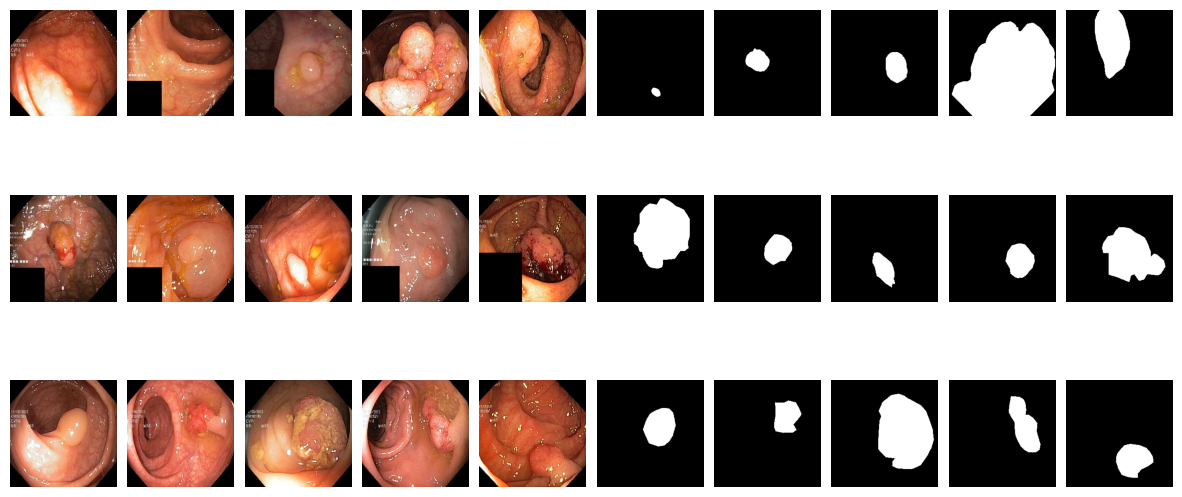

In [ ]:
# Set the number of rows and columns for the grid
num_rows = 3
num_cols = 5
total_images = num_rows * num_cols # total of 15 images to display

# Plot the images and masks in a grid
fig, axes = plt.subplots(num_rows, 2 * num_cols, figsize=(15, 7))

# Get the test batch
test_batch_images = test_images_gen.next()
test_batch_masks = test_masks_gen.next()

# Iterate over the images in the test batch and plot them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Plot the image
        axes[i, j].imshow(test_batch_images[index], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + num_cols].imshow(test_batch_masks[index], cmap='gray')
        axes[i, j + num_cols].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
print("Minimum test image pixel value:", batch_images[0].min())
print("Maximum test image pixel value:", batch_images[0].max())
print("Minimum test mask pixel value:", batch_masks[0].min())
print("Maximum test mask pixel value:", batch_masks[0].max())

Minimum test image pixel value: 0.0
Maximum test image pixel value: 1.0
Minimum test mask pixel value: 0.0
Maximum test mask pixel value: 1.0


Same as the train and validation batches, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="build-and-train-polyp-segmentation-model:-u-net"></a>
## Build and Train Polyp Segmentation Model: U-Net

<a name="what-is-u-net?"></a>
### What is U-Net?
The U-Net architecture is a type of convolutional neural network (CNN) designed for fast and precise segmentation of biomedical images. Originally, it was developed for biomedical image segmentation tasks such as neuronal structures in electron microscopic stacks. However, its versatility and efficacy have led to its adoption in a wide range of image segmentation tasks beyond biomedical applications. Some of its benefits are:

1. **Data Efficiency:** U-Net is known for being very data-efficient, meaning that it can produce good results even with a limited amount of training data.
2. **High Resolution:** The architecture is designed to produce high-resolution output, making it ideal for tasks that require identifying fine details in an image.
3. **Versatility:** Although it was initially developed for biomedical image segmentation, U-Net has been successfully adapted for various other types of image segmentation tasks.

Many subsequent architectures have either built upon or been inspired by the U-Net for various segmentation and even some non-segmentation tasks.

<a name="model-architercture"></a>
### Model architercture
The U-Net architecture can be visualized as a "U" shape, which gives it its name. Here's a breakdown of its structure:

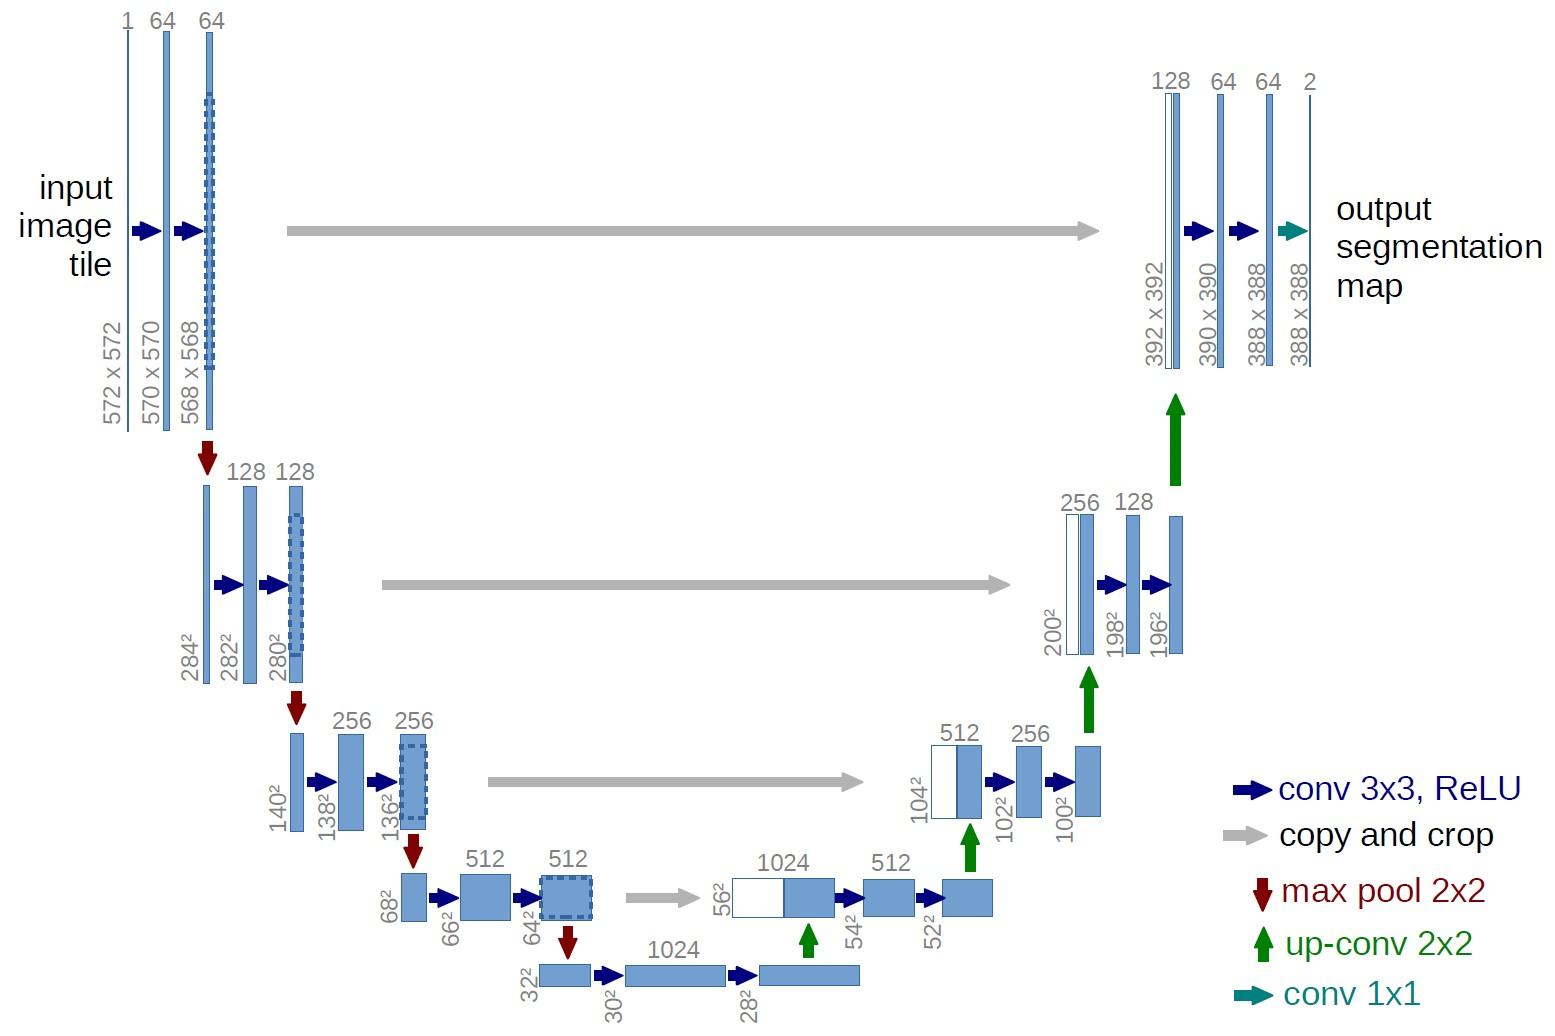

1. **Encoder (Downsampling Path):** The encoder captures the context in the image. It consists of a series of convolutional layers, batch normalization layers, activation functions (usually ReLU), and max-pooling layers. Each step down the U consists of two convolutions followed by a max-pooling operation to reduce the dimensions of the feature maps. This helps the network learn increasingly abstract features.

2. **Decoder (Upsampling Path):** The decoder enables precise localization using transposed convolutions. It consists of a series of up-convolutional layers (or transposed convolutions), concatenation with feature maps from the encoder (skip connections), followed by regular convolutions. The transposed convolutions increase the dimensions of the feature maps.

3. **Skip Connections:** These are the "bridges" between the encoder and decoder. They help the decoder recover the spatial information lost during encoding, which is crucial for achieving precise segmentation.

4. **Bottleneck:** This is the deepest layer in the U-Net, connecting the encoder and decoder. It usually consists of convolutions and activation functions but no pooling. This layer is responsible for the most abstract feature representations.

5. **Output Layer:** The final layer is a 1x1 convolution followed by an activation function like sigmoid (for binary segmentation) or softmax (for multi-class segmentation).

In [ ]:
# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
def conv_block(input, num_filters):
    """
    Create a block of two convolutional layers each followed by batch normalization and ReLU activation.

    Args:
        input (Tensor): Input tensor.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        x (Tensor): Output tensor after applying two convolutional layers, batch normalization, and ReLU activation.
    """

    # First convolutional layer
    x = Conv2D(num_filters, 3,
               #kernel_initializer='he_uniform',
               kernel_regularizer=l2(1e-5),
               padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    # Second convolutional layer
    x = Conv2D(num_filters, 3,
               #kernel_initializer='he_uniform',
               kernel_regularizer=l2(1e-5),
               padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    # Adding Dropout after the activation
    #x = Dropout(0.25)(x)
    return x

def encoder_block(input, num_filters):
    """
    Create an encoder block with a convolutional block followed by max-pooling.

    Args:
        input (Tensor): Input tensor.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        x (Tensor): Output tensor after the convolutional block.
        p (Tensor): Output tensor after max-pooling.
    """

    # Convolutional block
    # The conv output can be used for concatenation (skip connections) with decoder
    x = conv_block(input, num_filters)

    # Max-pooling
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    """
    Create a decoder block with a transposed convolutional layer and a convolutional block.

    Args:
        input (Tensor): Input tensor.
        skip_features (Tensor): Tensor from the encoder to be concatenated with the input.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        x (Tensor): Output tensor after the decoder block.
    """

    # Transposed convolutional layer
    x = Conv2DTranspose(num_filters, (2, 2),
                        strides=2,
                        #kernel_initializer='he_uniform',
                        kernel_regularizer=l2(1e-5),
                        padding="same")(input)

    # Concatenation with skip connection features
    x = Concatenate()([x, skip_features])

     # Convolutional block
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
     """
    Build a U-Net model for image segmentation.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        n_classes (int): Number of classes for segmentation.

    Returns:
        model (Model): U-Net model.
    """
    inputs = Input(input_shape)

    # Encoder blocks
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder blocks
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer: choose activation function based on the number of classes
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4) #Change the activation based on n_classes
    print(f"Output activation: {activation}")

    model = Model(inputs, outputs, name="U-Net")
    return model

In our implementation, we have added Batch Normalization layers to stabilize the training. We have also experimented with adding the Dropout layer, and trying with different L2 regularizer strength (1e-6 to 1e-3) and different initializer (He normal and Glorot uniform - default).

The best combination that gives us the best model performance for our task is to have no Dropout layer, default initializer, and L2 regularizer with L2 regularization factor of 1e-5.

<a name="model-configuration"></a>
### Model configuration

In this section, we will configure our U-Net model for training. Before we do that, we will set parameterrs to build our U-Net model.

In [ ]:
# Get the shape of the input images
x = train_images_gen.__next__()
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Number of classes (binary segmentation)
n_classes = 1

We can do a quick check to confirm the batch size, input shape, and output shape.

In [ ]:
# sanity check
x.shape[0] #batch size

16

In [ ]:
# sanity check
input_shape #input shape

(256, 256, 3)

In [ ]:
# sanity check
y = train_masks_gen.__next__()
y.shape[1:] #target shape

(256, 256, 1)

In order to successfully compile the model, we will need to input the optimizer, loss function, and metrics correctly. We will use the typical Accuracy metric which calculates how often the predictions equal labels, and experiment with different combinations of optimizer (Adam and Nadam) and loss (Binary Crossentropy, Dice Loss, and IoU Loss) functions.

In [ ]:
# Define Dice coefficient for evaluating segmentation performance
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

# Define Dice loss based on Dice coefficient
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

# Define IoU (Intersection over Union) coefficient
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Define IoU loss based on IoU coefficient
def iou_loss(y_true, y_pred):
    loss = 1 - iou_coefficient(y_true, y_pred)
    return loss

# Learning rate
lr = 1e-4

In [ ]:
# Build and compile the U-Net model
model = build_unet(input_shape, n_classes=n_classes)

# Compile the model with different loss functions and optimizers
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=['accuracy'])
#model.compile(optimizer=Adam(lr), loss=iou_loss, metrics=['accuracy'])
#model.compile(optimizer=Nadam(lr), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Nadam(lr), loss=dice_loss, metrics=['accuracy'])
#model.compile(optimizer=Nadam(lr), loss=iou_loss, metrics=['accuracy'])

# Display the model's architecture
model.summary()

Output activation: sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                  

After experimenting with different loss functions and optimizers, the best combination that gives us the best model performance for our task is the Adam optimzer with Binary Crossentropy loss function.

<a name="model-training"></a>
### Model training

Once the model has successfully compiled, we are now ready to train the model. Below are some key points to set up the training correctly:

1. **Epochs and Steps:** We've set the number of epochs to 120 and calculated the steps per epoch based on the training data.

2. **Model Checkpoint:** We're saving the best model based on validation loss, which allows us to resume training or make predictions later.

3. **Early Stopping:** We've implemented early stopping with a patience of 10 epochs, which is to prevent overfitting and reduce training time.

4. **Learning Rate Reduction:** We're using `ReduceLROnPlateau` to reduce the learning rate if the validation loss plateaus, which can help the model converge to a better solution.

5. **Training:** We're using the `fit` method with our training and validation data generators, which follows the standard way to train a Keras model.

6. **Callbacks:** We've included multiple callbacks (`model_checkpoint`, `early_stopping`, and `reduce_lr`) to monitor and adjust the training process.

In [ ]:
# Set parameters for training
epochs = 120
steps_per_epoch = train_images_gen.samples // train_images_gen.batch_size
validation_steps = validation_images_gen.samples // validation_images_gen.batch_size

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
checkpoint_path = './model/unet.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)

# Fit the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.7323
Epoch 1: val_loss improved from inf to 0.71582, saving model to ./model/unet_checkpointv2b_7a1.h5
50/50 [==============================] - 415s 8s/step - loss: 0.5864 - accuracy: 0.7323 - val_loss: 0.7158 - val_accuracy: 0.8163 - lr: 1.0000e-04
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8384
Epoch 2: val_loss improved from 0.71582 to 0.61529, saving model to ./model/unet_checkpointv2b_7a1.h5
50/50 [==============================] - 23s 467ms/step - loss: 0.4382 - accuracy: 0.8384 - val_loss: 0.6153 - val_accuracy: 0.8249 - lr: 1.0000e-04
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8340
Epoch 3: val_loss improved from 0.61529 to 0.60653, saving model to ./model/unet_checkpointv2b_7a1.h5
50/50 [==============================] - 23s 467ms/step - loss: 0.4147 - accuracy: 0.8340 - val_loss: 0.6065 - val_ac

When the training is completed, the `fit` method will return a **History** object, which is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.

Let's now plot them out and see how the model is performing.

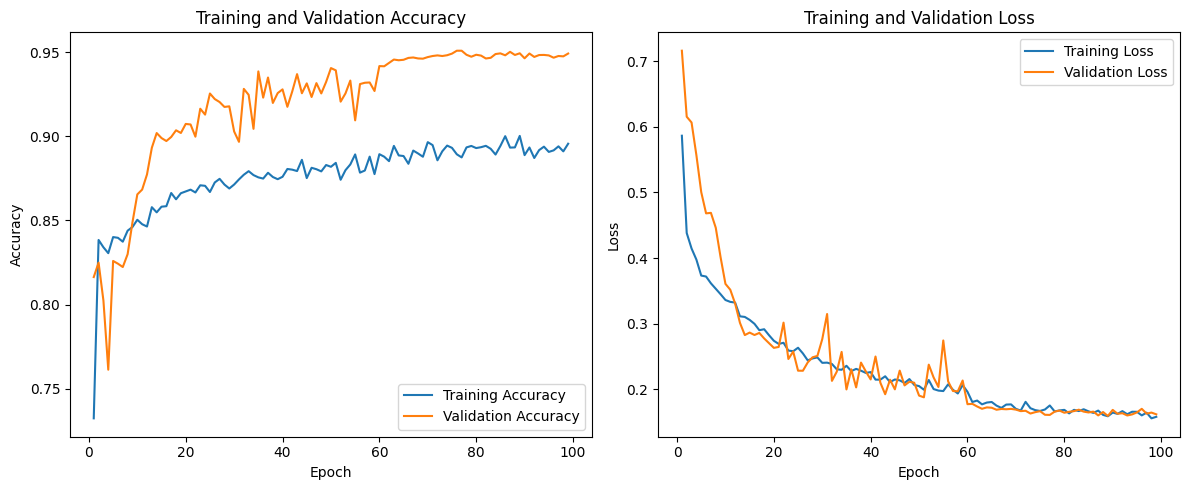

In [ ]:
# Get the history of accuracy and loss from the `history` object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Based on the training history, we can conclude that:
- The validation loss is generally decreasing, which is a sign that the model is learning to generalize well on unseen data. The lowest validation loss is 0.15967 at Epoch 89.

- The training accuracy is fluctuating around 88-90%, which suggests that the model is performing reasonably well on the training data.

- The validation accuracy is generally higher than the training accuracy, often exceeding 94%. This is a positive sign, indicating that the model is not overfitting and is generalizing well to new data.

Overall, the model appears to be performing well. The validation metrics are strong, and there's no immediate sign of overfitting. However, in image segmentation, accuracy might not always be the most informative metric for evaluating model performance because the classes are usually imbalanced.

For example, the object of interest (e.g., the polyp) might occupy a very small portion of the image. A model that predicts every pixel as the majority class (background) could still achieve high accuracy but would perform poorly on predicting the minority class (object of interest).

Therefore, in the next section, we will look into other metrics that are more suitable for evaluating the segmentation performance.



<a name="evaluate-trained-u-net-model"></a>
## Evaluate Trained U-Net Model

Other than accuracy, the other metrics that are often used in evaluating segmentation performance are:
- Precision
- Recall
- IoU (Intersection over Union)
- Dice Coefficient

The metric value ranges of all presented metrics span from 0 (worst) to 1 (best), and we will talk about each metrics in detail in the upcoming sections, now let's first load our trained model.

In [ ]:
# Load the saved model
saved_model_path = './model/unet.h5'
loaded_model = tf.keras.models.load_model(saved_model_path)

<a name="confusion-matrix"></a>
### Confusion matrix

All presented metrics above are based on the computation of a **confusion matrix**, which represent the number of pixels that were correctly or incorrectly classified as either the object of interest or the background.

Let's conduct a confusion matrix and see how the U-Net model performs on test set.

4/4 [==============================] - 5s 97ms/step
[[5361958   89861]
 [ 222039  879742]]


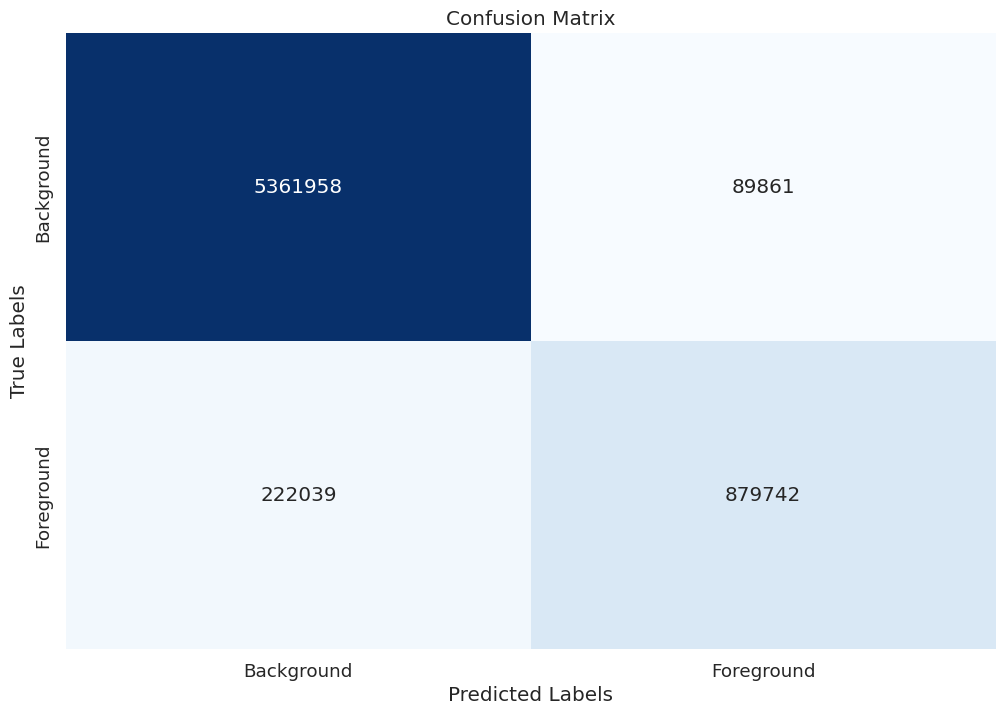

In [ ]:
test_image = test_images_gen[0]
test_mask = test_masks_gen[0]

# Generate predictions for the test image
prediction = loaded_model.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Convert masks to 1D arrays and flatten them
test_mask_flat = test_mask.ravel()
binary_prediction_flat = binary_prediction.ravel()

# Convert binary masks to binary labels (0 or 1)
test_mask_labels = (test_mask_flat > 0).astype(np.uint8)
binary_prediction_labels = (binary_prediction_flat > 0).astype(np.uint8)

# Create the confusion matrix
conf_mat = confusion_matrix(test_mask_labels, binary_prediction_labels)
print(conf_mat)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

From the confusion matrix, we can observe that:
- **True Positive (TP):** 879,742 pixels were correctly identified as the object of interest.
- **True Negative (TN):** 5,361,958 pixels were correctly identified as the background.
- **False Positive (FP):** 89,861 pixels were incorrectly identified as the object of interest.
- **False Negative (FN):** 222,039 pixels were incorrectly identified as the background.

<a name="precision-and-recall"></a>
### Precision and Recall

**Precision**, also known as the *Positive Predictive Value (PPV)*, measures the proportion of true positive predictions among all the positive predictions made by the model. In other words, it answers the question: "Of all the instances that the model labeled as positive, how many are actually positive?"

$$
\text{Precision} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP) + False Positive (FP)}}
$$
<br>
Precision is more concerned with the purity of the positive predictions, aiming to **minimize false positives**.

**Recall** score, also known as *Sensitivity* or *true positive rate*, measures the proportion of true positives among all the actual positives. It answers the question: "Of all the actual positive instances, how many did the model correctly identify?"

$$
\text{Recall} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP) + False Negative (FN)}}
$$
<br>
Recall is more concerned with capturing all the possible positive instances, aiming to **minimize false negatives**.

As discussed, we can use the values from the confusion matrix (TP, TN, FP, and FN) to calculate evaluation metrics such as precision, recall, IoU, and dice coefficient, which provide a comprehensive assessment of the model's segmentation performance.

Let's have a look at the classification report below which summarizes two of our interested metrics: precision and recall.

In [ ]:
class_names = ["Background", "Foreground"]

# Generate the classification report
report = classification_report(test_mask_labels, binary_prediction_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

  Background       0.96      0.98      0.97   5451819
  Foreground       0.91      0.80      0.85   1101781

    accuracy                           0.95   6553600
   macro avg       0.93      0.89      0.91   6553600
weighted avg       0.95      0.95      0.95   6553600



The model is more conservative in predicting the foreground class, as indicated by the high precision but lower recall. This means that the model is missing some pixels that should be classified as foreground.

The model performs exceptionally well in classifying the background, as indicated by the high scores across all metrics.

In summary, the model performs fairly well but could benefit from techniques aimed at improving the recall for the foreground class.

<a name="iou-and-dice-coefficient-(f1-score)"></a>
### IoU and Dice coefficient (F1 score)

F-measure, also called F-score, is one of the most widespread scores for performance measuring in MIS (Medical Image Segmentation). Based on the F-measure, there are two popular utilized metrics in MIS:
- Intersection over Union (IoU)
- Dice coefficient
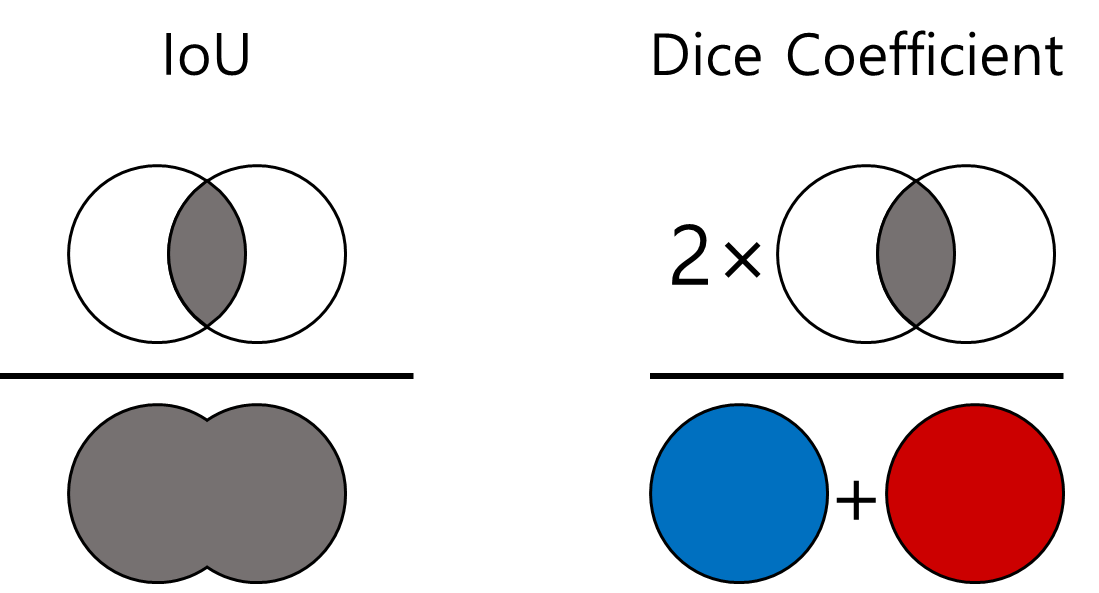

**Intersection over Union (IoU)**, also known as *Jaccard index*, is the area of the intersection over union of the predicted segmentation and the ground truth.
$$
IoU = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}
$$
<br>

**Dice coefficient = F1-score**, is the harmonic mean of precision and recall. In another words, dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images
$$
Dice = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}}
$$
<br>

After evaluating the model from the precision and recall perspective, let's now have a look at the IoU and Dice coefficient.

In [ ]:
# Initialize variables to store the total intersection, union, and sums for Dice coefficient
total_intersection = 0
total_union = 0
total_dice_numerator = 0
total_dice_denominator = 0

# Get the total number of samples in the test set
num_samples = len(test_masks_gen)

# Define a function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_numerator = 2.0 * intersection
    dice_denominator = np.sum(y_true) + np.sum(y_pred)
    return dice_numerator, dice_denominator

# Compute Intersection over Union (IoU) and Dice coefficient for each batch in the test set
for i in range(num_samples):
    # Get the next batch of test images and masks
    batch_images = test_images_gen[i]
    batch_masks = test_masks_gen[i]

    # Generate predictions for the batch
    batch_predictions = loaded_model.predict(batch_images, verbose=0)

    # Threshold the predictions to obtain binary masks
    binary_predictions = (batch_predictions > 0.5).astype(np.uint8)

    # Compute intersection and union for the batch
    intersection = np.logical_and(batch_masks, binary_predictions)
    union = np.logical_or(batch_masks, binary_predictions)

    # Compute Dice coefficient for the batch
    dice_numerator, dice_denominator = dice_coefficient(batch_masks, binary_predictions)

    # Update the totals
    total_intersection += np.sum(intersection)
    total_union += np.sum(union)
    total_dice_numerator += dice_numerator
    total_dice_denominator += dice_denominator

# Compute the mean IoU and Dice coefficient across all batches
mean_iou = total_intersection / total_union
mean_dice = total_dice_numerator / total_dice_denominator

# Print the mean IoU and Dice coefficient
print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice Coefficient: {mean_dice}")

Mean IoU: 0.7382603164373193
Mean Dice Coefficient: 0.8566933243478139


An IoU of 0.738 is reasonably good, indicating that a significant portion of the ground truth overlaps with the predicted segmentation.

A Dice Coefficient of 0.857 is also strong, suggesting a high degree of overlap between the predicted and ground truth segments. Dice Coefficients close to 1 are indicative of excellent model performance.

<a name="mask-prediction"></a>
### Mask prediction

We have investigated 4 evaluation metrics: precision, recall, IoU, and dice coefficient to understand how well our model is segmenting the polyps. Now, we can perform a qualitative assessment (visual inspections) to get a comprehensive view of our model's performance.

4/4 [==============================] - 0s 140ms/step
Random indices: [6, 34, 11, 98, 52]


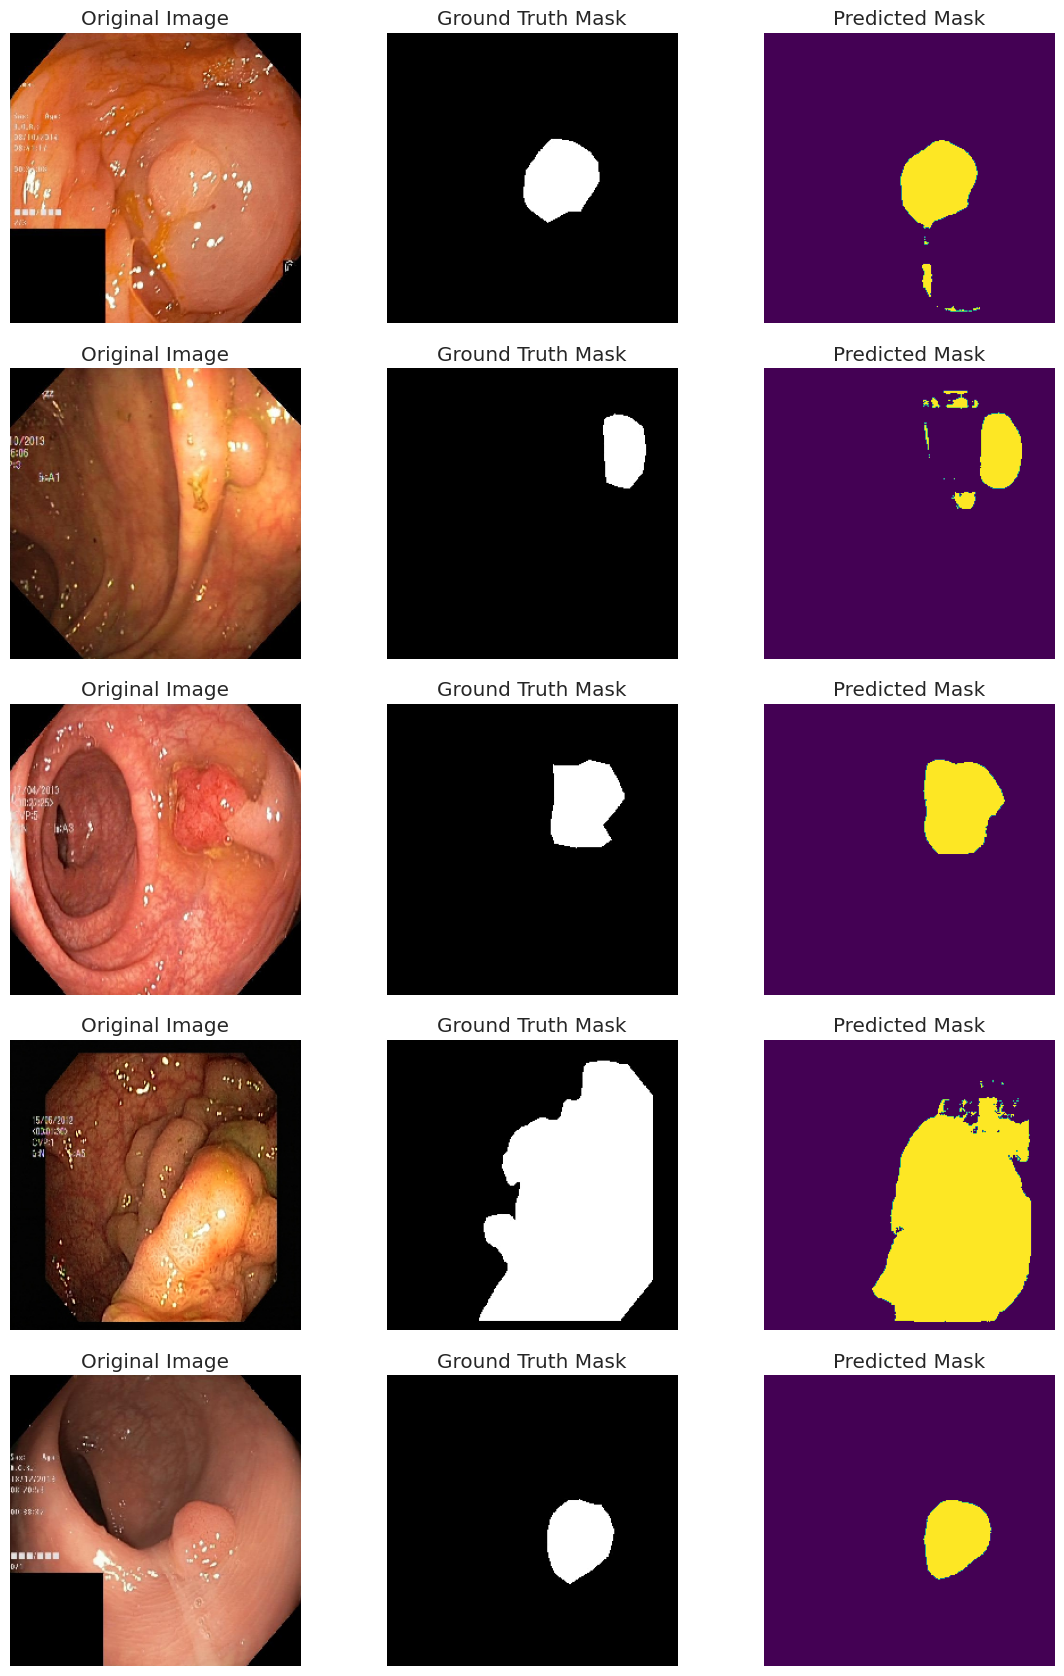

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Get the corresponding test image and mask (from only 1 batch)
test_image = test_images_gen[0]
test_mask = test_masks_gen[0]

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_model.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

The predicted segmentation mask exhibits a high degree of morphological similarity to the ground truth, capturing the overall shape and contours of the target region. However, there are subtle discrepancies in the boundary delineations, indicating that the model's spatial accuracy could be further optimized. Instead of using the standard U-Net, we can try other models that were specifically designed to improve boundary delineation in segmentation tasks, such as V-Net, DeepLab, Mask R-CNN, and many more.

We can also observe that there is presence of spurious detections or false positives in the predicted mask, which has a detrimental effect on the model's precision. These inaccuracies indicate that the model is overly optimistic in identifying polyps. To solve this, we can increase the prediction threshold by reducing the number of false positives, but it may also reduce the model's sensitivity to true positives. In a medical context, this is a delicate balance that should be struck carefully, ideally in consultation with the clinical experts.

<a name="conclusion"></a>
## Conclusion

Certainly, we can wrap up the discussion on the model's performance with its strength, areas of improvement, and recommendations.

<a name="strengths"></a>
### Strengths
1. **High Accuracy**: The model shows a high overall accuracy of 95%, which is promising.
2. **Good Precision and Recall**: Both metrics are above 80%, indicating that the model is generally reliable for both identifying and correctly classifying the target regions.
3. **Morphological Similarity**: The model does a good job of capturing the overall shape and contours of the target.

<a name="areas-for-improvement"></a>
### Areas for Improvement
1. **Boundary Delineation**: The model could be improved in terms of its spatial accuracy, particularly at the boundaries of the target region.
2. **False Positives**: The presence of spurious detections indicates room for improvement in precision.

<a name="recommendations"></a>
### Recommendations
1. **Threshold Tuning**: Fine-tune the prediction threshold to balance false positives and false negatives.
2. **Loss Functions**: Custom loss functions like boundary loss or Hausdorff distance loss can be used to train the model to pay more attention to boundaries.
3. **Data Augmentation**: Use more diverse training data or apply techniques like boundary jitter can be used during training to make the model more robust to boundary variations.
4. **Attention Mechanisms**: Spatial attention mechanisms can help the model focus on boundary regions.

<a name="limitations-of-u-net-architecture"></a>
## Limitations of U-Net Architecture

The standard U-Net architecture, while effective for many segmentation tasks, has some limitations:
1. **Limited Contextual Information**: U-Net captures local features well but may struggle with global contextual information that can be important for some segmentation tasks.

2. **Fixed Architecture**: The architecture is generally fixed and not easily adaptable to different scales or types of data.

3. **Boundary Delineation**: U-Net can sometimes produce segmentation masks that are not as precise at the boundaries, which is a significant issue in medical imaging where the exact boundary is often crucial for diagnosis.

4. **Memory Consumption**: The architecture can be memory-intensive, especially for 3D segmentation tasks.

5. **Generalization**: U-Net may not generalize well to out-of-distribution data or to cases that are significantly different from the training data.

6. **Small Object Detection**: Detecting small or thin objects can be challenging for U-Net, as the architecture may focus more on the dominant classes.

7. **Class Imbalance**: U-Net does not inherently handle class imbalance well, which is often a problem in medical imaging where the object of interest is much smaller than the background.

8. **Lack of Attention Mechanisms**: Standard U-Net does not include attention mechanisms that could help it focus on more important regions of the image.

9. **Texture and Fine Details**: While U-Net is good for capturing the overall shape, it may not capture texture and fine details as effectively.

10. **Inter-Class Variability**: U-Net may struggle with high inter-class variability, where objects of the same class have different appearances.

11. **Computational Efficiency**: While U-Net is relatively simple, it may not be the most computationally efficient model for all tasks, especially when real-time inference is required.

<a name="current-state-of-art-model:-meta-polyp"></a>
### Current state of art model: Meta-Polyp
According to the website [Papers with Code](https://paperswithcode.com/sota/medical-image-segmentation-on-kvasir-seg), the current state-of-the-art model on Kvasir-SEG is the [Meta-Polyp](https://arxiv.org/pdf/2305.07848.pdf), which is a recent development as of 2023. The model suggests that the proposed model, which is a fusion of MetaFormer with UNet, outperforms standard UNet architectures, especially on challenging aspects like out-of-distribution datasets, missing boundaries, and small polyps. The authors claim that their approach achieved top results on multiple datasets, including CVC-300, Kvasir, and CVC-ColonDB.
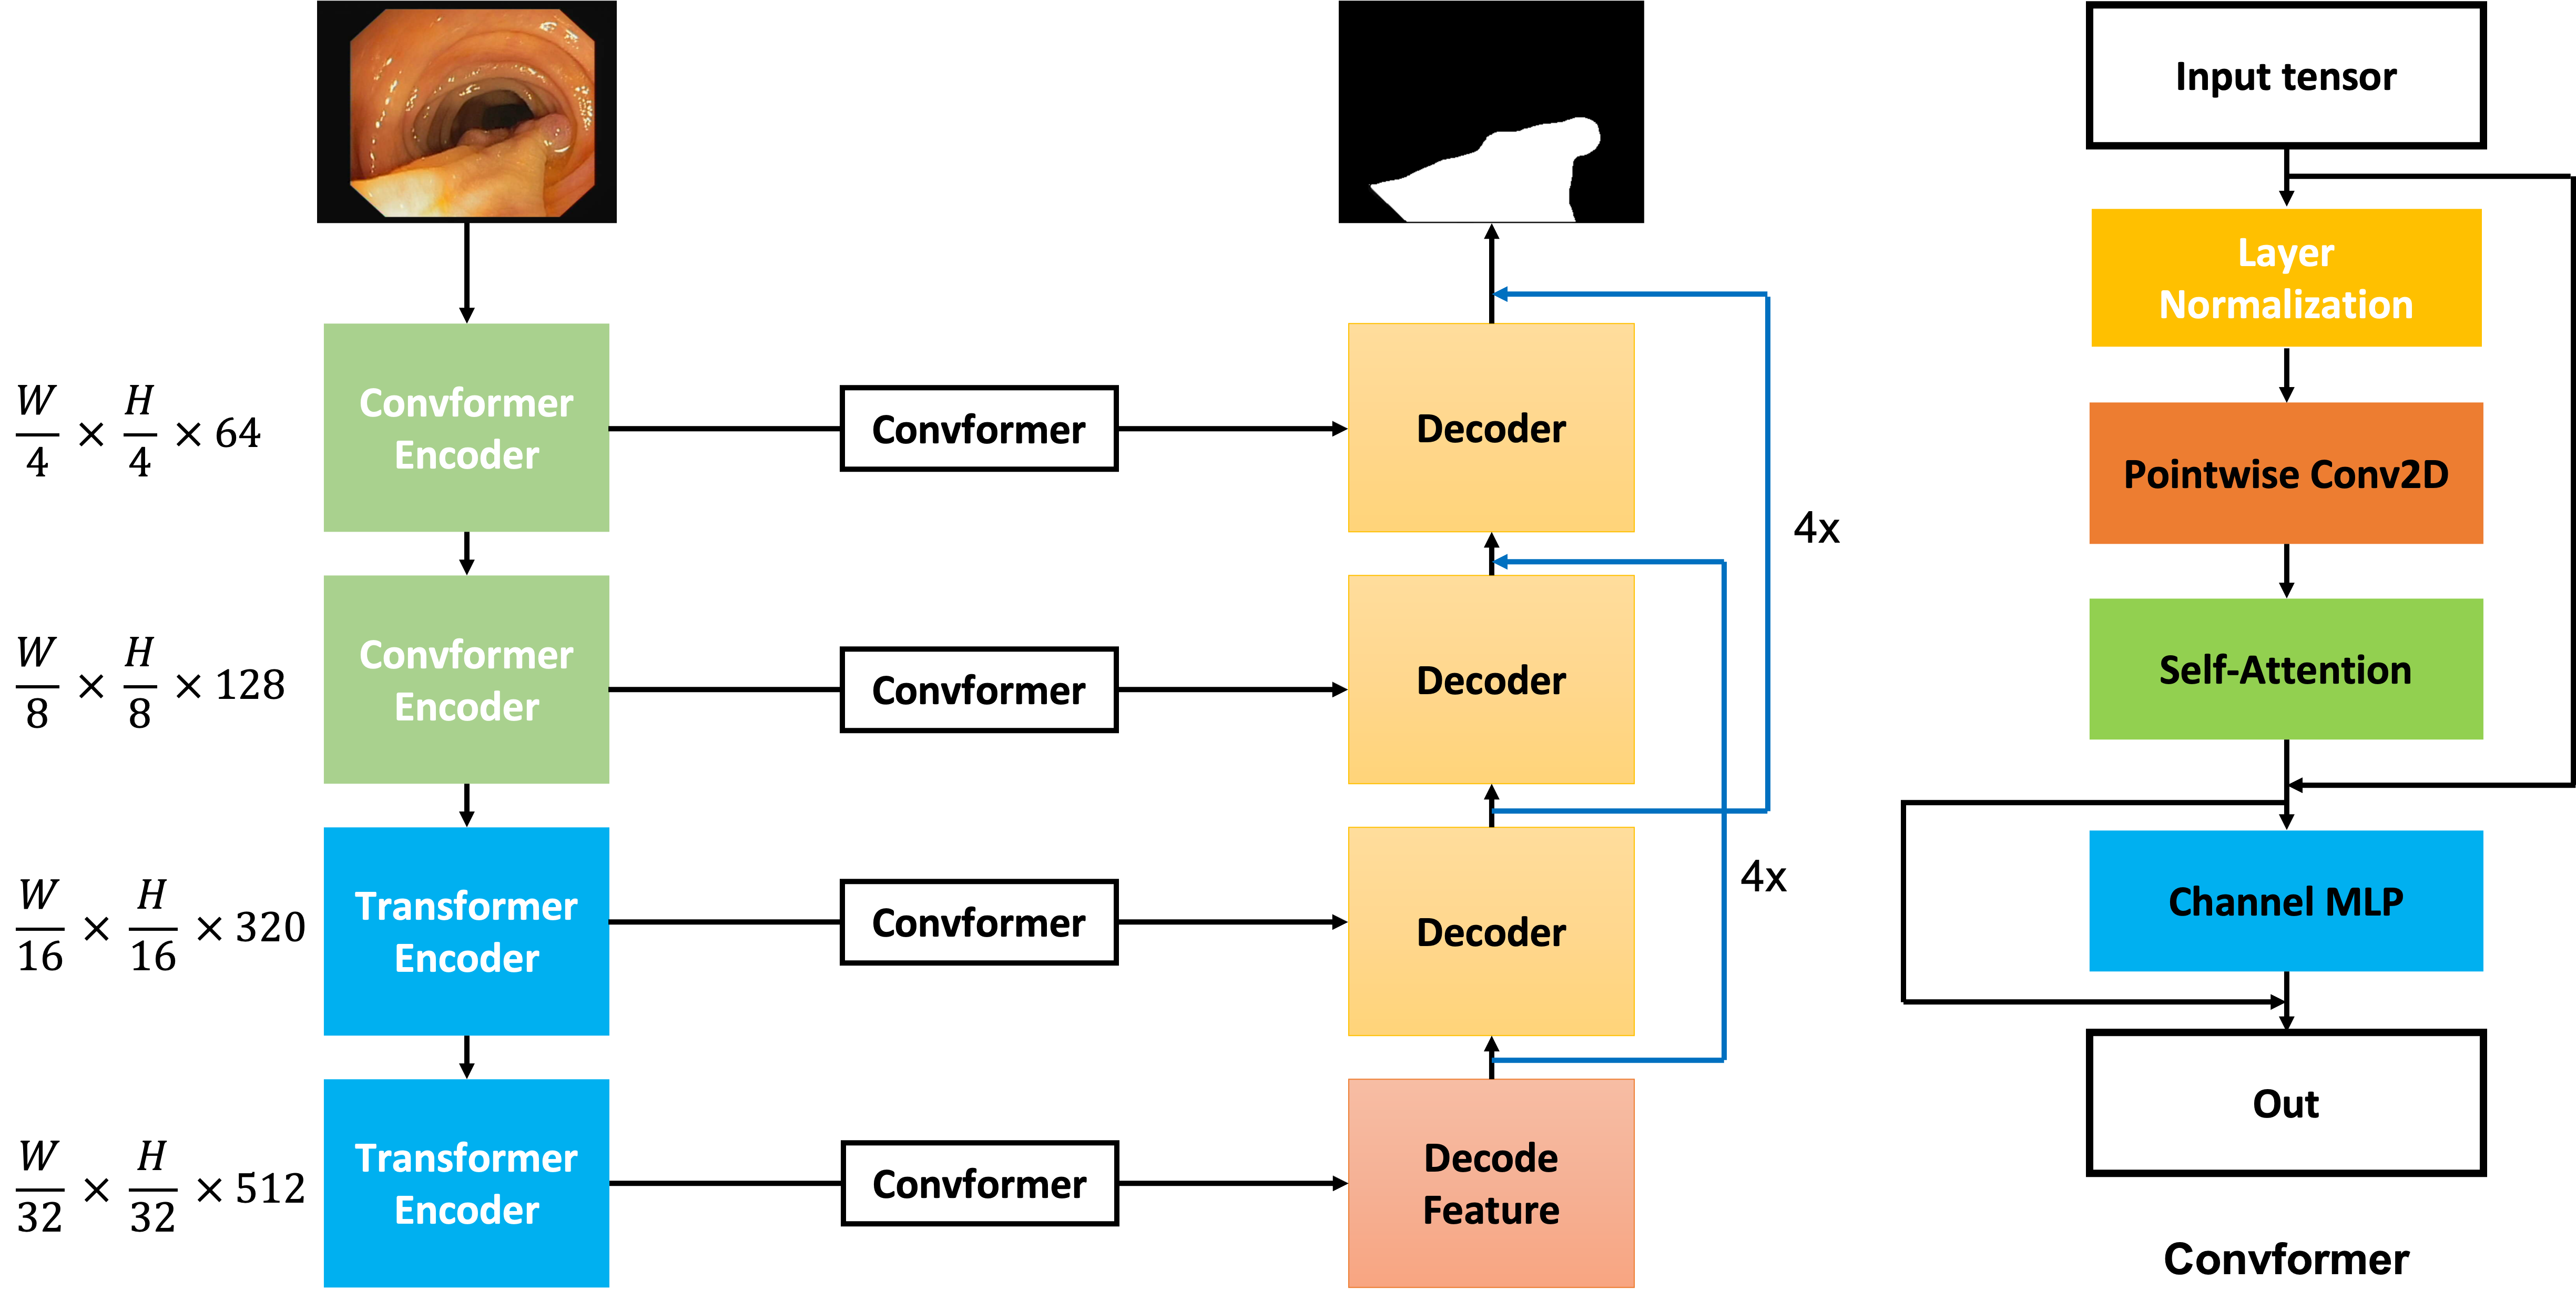

Therefore, it appears that the proposed model is designed to be an improvement over standard U-Net models, particularly in handling more complex and varied datasets.